In [1]:
pip install opencv-python ultralytics

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm  
import pandas as pd
import numpy as np
from PIL import Image
from collections import defaultdict
import random
from ultralytics import YOLO
import mlflow


# DATA Validation

In [2]:
# validate image extension & labels & classes
paths ={"train": '../data/raw/BoneFractureYolo8/train',"val":"../data/raw/BoneFractureYolo8/valid", "test" : '../data/raw/BoneFractureYolo8/test'}
count_img = {}
countlabel = {}
count_classes = {}
valid_ext = ['.png','.jpg','.jpeg']
valid_classes = [ str(i) for i in range(7)]
for key,path in paths.items():
    image_direc = os.path.join(path,'images')
    label_direc = os.path.join(path,'labels')
    imag_counter = 0
    label_counter = 0
    classes_counter = 0
    for img in os.listdir(image_direc):
        image,extension = os.path.splitext(img)
        if extension.lower() not in valid_ext:
            imag_counter += 1
        label = image +'.txt'
        ref_label = os.path.join(label_direc,label)
        if not os.path.exists(ref_label):
            label_counter += 1
        else:
            with open(ref_label,'r') as file:
                content = file.read()
                if (len(content) != 0) and (content[0] not in valid_classes):
                    classes_counter += 1

    count_img[key] = imag_counter
    countlabel[key] = label_counter
    count_classes[key] = classes_counter


In [3]:
results = {
    'Corrupted image counts': count_img,
    'Missing label counts': countlabel, 
    'Invalid Classes counts': count_classes
}

df = pd.DataFrame(results)


In [4]:
df

,Corrupted image counts,Missing label counts,Invalid Classes counts
train,0,0,0
val,0,0,0
test,0,0,0


In [5]:
# RGB Validation
def is_rgb(image_path):
    img = Image.open(image_path)
    return img.mode == 'RGB'

def check_rgb(dir):
    rgb_count = 0
    for filename in os.listdir(dir):
        if is_rgb(os.path.join(dir, filename)):
            rgb_count += 1
    return rgb_count

In [ ]:
print(f'RGB count for train images: {check_rgb(r"../data/raw/BoneFractureYolo8/train/images")}')
print(f'RGB count for val images: {check_rgb(r"../data/raw/BoneFractureYolo8/valid/images")}')
print(f'RGB count for test images: {check_rgb(r"../data/raw/BoneFractureYolo8/test/images")}')

RGB count for train images: 3631
RGB count for val images: 348
RGB count for test images: 169


In [7]:
def check_size(dir):
    dictionary = {}
    for idx, filename in enumerate(os.listdir(dir)):
        img_path = os.path.join(dir, filename)
        img = cv2.imread(img_path)
        dictionary[idx] = img.shape[:2]
    return dictionary


In [8]:
dict_train = check_size('../data/raw/BoneFractureYolo8/train/images')

In [9]:
train_df = pd.DataFrame(dict_train).T

In [10]:
train_df.shape

(3631, 2)

In [11]:
train_df.describe()

,0,1
count,3631.000000,3631.000000
mean,485.741944,412.033324
std,77.925944,115.399559
min,134.000000,111.000000
25%,492.000000,379.000000
50%,512.000000,420.000000
75%,512.000000,512.000000
max,2048.000000,2048.000000


In [ ]:
dict_test= check_size('../data/raw/BoneFractureYolo8/test/images')
test_df = pd.DataFrame(dict_test).T
test_df.shape

(169, 2)

In [13]:
test_df.describe()

,0,1
count,169.000000,169.000000
mean,488.467456,413.355030
std,136.473268,105.766384
min,160.000000,119.000000
25%,473.000000,379.000000
50%,512.000000,420.000000
75%,512.000000,512.000000
max,2048.000000,801.000000


In [14]:
# Checking classes distribution
def class_dis(label_path):
    class_dist = defaultdict(int)
    for x in os.listdir(label_path):
        ref_label = os.path.join(label_path,x)
        with open(ref_label,'r') as file:
                content = file.read()
                if (len(content) != 0):
                    class_dist[content[0]] += 1
                else:
                    class_dist['-1'] +=1
    return class_dist

In [ ]:
train_label = class_dis('../data/raw/BoneFractureYolo8/train/labels')
train_label

defaultdict(int,
            {'0': 306,
             '-1': 1827,
             '5': 315,
             '6': 168,
             '4': 299,
             '2': 283,
             '1': 433})

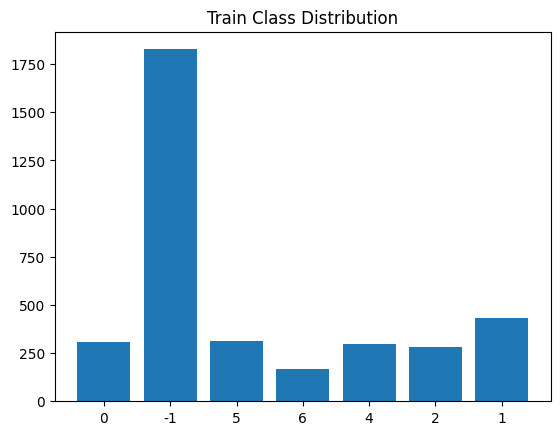

In [ ]:
plt.bar(train_label.keys(), train_label.values())
plt.title('Train Class Distribution')
plt.show()

In [17]:
test_label = class_dis('../data/raw/BoneFractureYolo8/test/labels')
test_label

defaultdict(int,
            {'0': 13, '-1': 86, '5': 15, '4': 14, '6': 6, '2': 13, '1': 22})

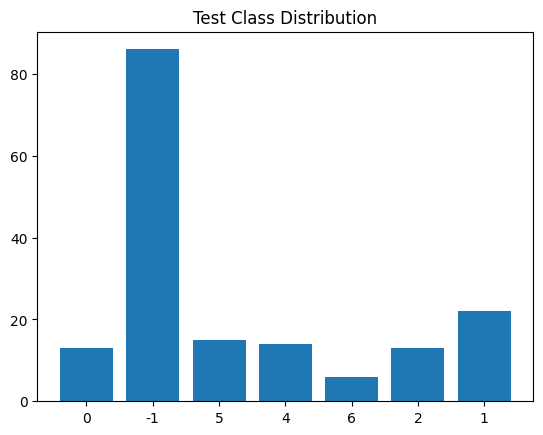

In [ ]:
plt.bar(test_label.keys(), test_label.values())
plt.title('Test Class Distribution')
plt.show()

# DATA Processing

In [19]:
def process_dataset(paths, output_dir='../data/processed'):
    valid_ext = ['.png', '.jpg', '.jpeg']
    valid_classes = [str(i) for i in range(7)]
 
    for split, path in paths.items():
        img_dir = os.path.join(path, 'images')
        label_dir = os.path.join(path, 'labels')
        processed_img_dir = os.path.join(output_dir, split, 'images')
        processed_label_dir = os.path.join(output_dir, split, 'labels')
        os.makedirs(processed_img_dir, exist_ok=True)
        os.makedirs(processed_label_dir, exist_ok=True)
        for img_file in tqdm(os.listdir(img_dir), desc=f'Processing {split}'):
            img_path = os.path.join(img_dir, img_file)
            name, ext = os.path.splitext(img_file)
            label_file = f"{name}.txt"
            label_path = os.path.join(label_dir, label_file)
            
            invalid = False
            if ext.lower() not in valid_ext:
                invalid = True
            if not os.path.exists(label_path):
                invalid = True
            else:
                with open(label_path, 'r') as f:
                    content = f.read().strip()
                    if content:
                        first_char = content.split()[0]
                        if first_char not in valid_classes:
                            invalid = True
            if not invalid:
                with Image.open(img_path) as img:
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    resized_img = img.resize((640, 640))
                processed_img_path = os.path.join(processed_img_dir, img_file)
                resized_img.save(processed_img_path)
                shutil.copy2(label_path, os.path.join(processed_label_dir, label_file))


In [20]:
process_dataset(paths)

Processing train:   4%|▍         | 144/3631 [00:01<00:30, 114.81it/s]

Processing test: 100%|██████████| 169/169 [00:01<00:00, 128.95it/s]


In [21]:
# test
x = '../data/processed/train/images/elbow-dislocation-with-coronoid-process-fracture_jpg.rf.75b67d2e40fe637ba2838e1283f970c5.jpg'
y = cv2.imread(x)
print(y.shape)
is_rgb(x)

(640, 640, 3)


True

# Images Visualization

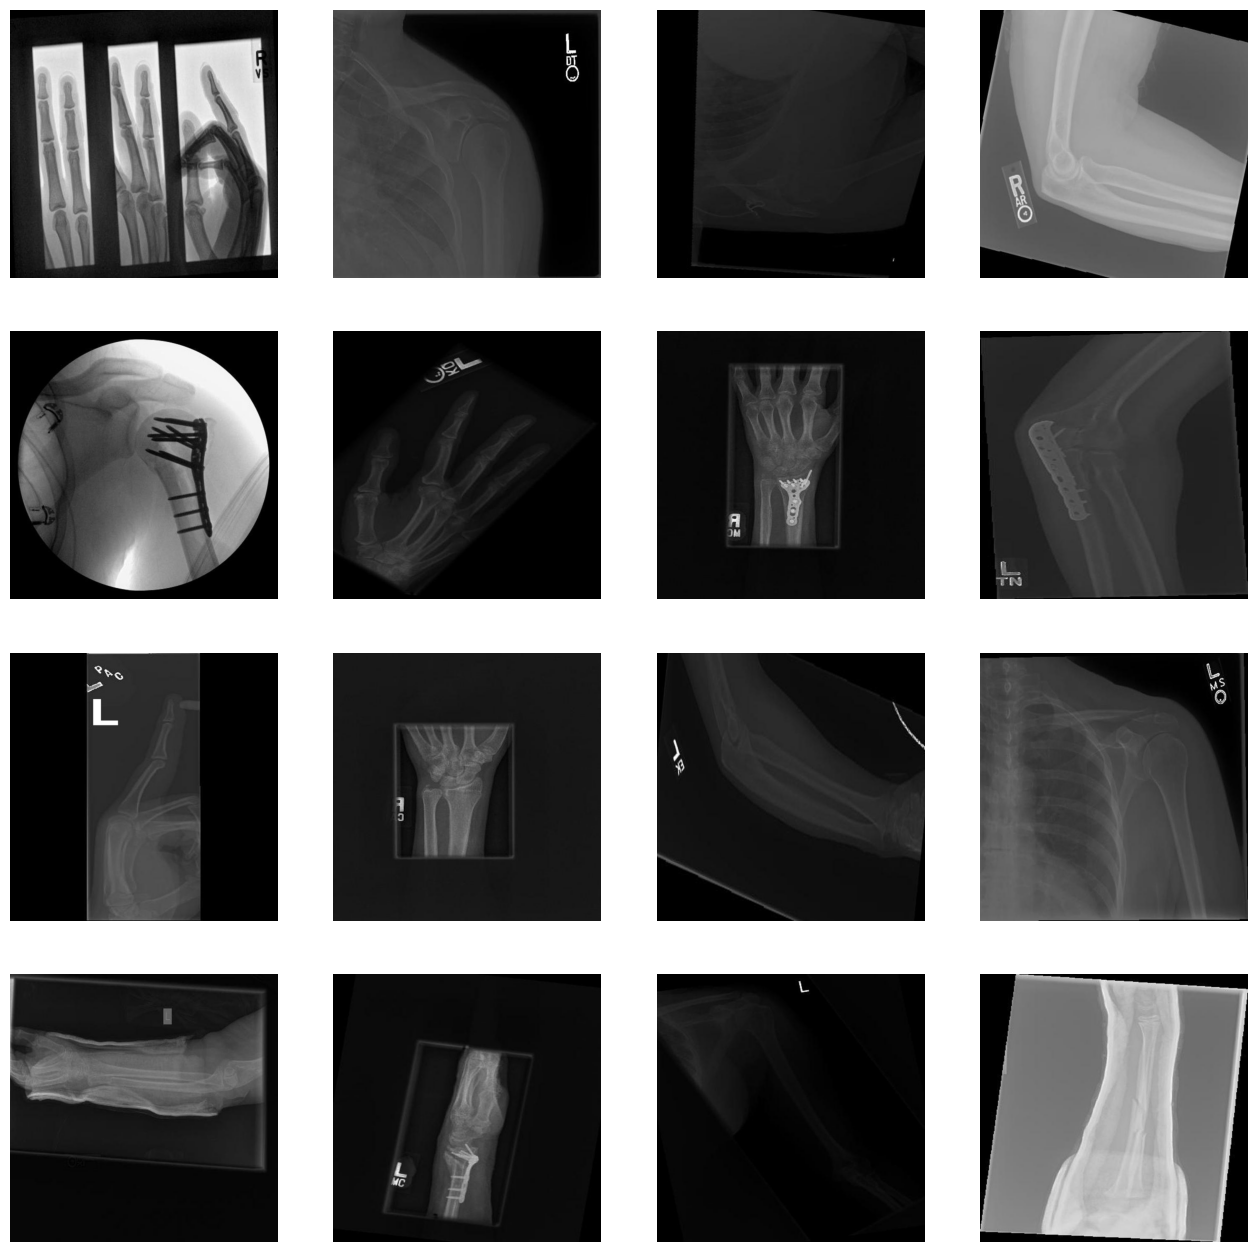

In [22]:
train_imgs = '../data/processed/train/images'
images_file = os.listdir(train_imgs)
random_images = random.sample(images_file, 16)
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    image_path = os.path.join(train_imgs, image_file)
    image = cv2.imread(image_path)
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')
plt.show()

# Model

In [30]:
from mlflow.tracking import MlflowClient

from pytorch_lightning import Trainer
trainer = Trainer(accelerator="gpu", devices="auto")
# os.environ["MLFLOW_TRACKING_USERNAME"] = "your_username"
# os.environ["MLFLOW_TRACKING_PASSWORD"] = "your_token"


mlflow.set_tracking_uri("https://dagshub.com/abdelrahman.samir/bone-fracture-detection.mlflow")

experiment_name = "bonefracture_yolov8s"
# mlflow.create_experiment(experiment_name)
mlflow.autolog()
client = MlflowClient()

experiments = client.search_experiments()
for exp in experiments:
    print(f"ID: {exp.experiment_id}, Name: {exp.name}")

mlflow.set_experiment(experiment_name)

model = YOLO('yolov8s.pt')
# model.set_class_weights(class_weights)
model.train(
    data="/teamspace/studios/this_studio/bone-fracture-detection/data/data.yaml",
    augment=True, 
    device = 0,
    imgsz=640,
    epochs=50,
    batch=16,
    verbose=True,
    name="bonefracture_yolov8s",
)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
2025/06/01 07:16:37 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/0

Ultralytics 8.3.146 🚀 Python-3.10.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA L40S, 45596MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/teamspace/studios/this_studio/bone-fracture-detection/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bonefracture_yolov8s7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience

train: Scanning /teamspace/studios/this_studio/bone-fracture-detection/data/processed/train/labels.cache... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 499.7±228.6 MB/s, size: 15.3 KB)


val: Scanning /teamspace/studios/this_studio/bone-fracture-detection/data/processed/val/labels.cache... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<?, ?it/s]


Plotting labels to runs/detect/bonefracture_yolov8s7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)


2025/06/01 07:16:41 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.
2025/06/01 07:16:41 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/06/01 07:16:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/06/01 07:16:41 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 1.9.0 <= torch <= 2.6.0, but the installed version is 2.7.0+cu128. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.
2025/06/01 07:16:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightning.
2025/06/01 07:16:41 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible

MLflow: logging run_id(aa0d9972bf3d4dfe93b5a0dbf7726740) to https://dagshub.com/abdelrahman.samir/bone-fracture-detection.mlflow
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/bonefracture_yolov8s7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.95G      2.805      8.294      2.527         16        640: 100%|██████████| 227/227 [00:18<00:00, 12.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.36it/s]

                   all        348        204      0.517    0.00775    0.00494    0.00141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.42G      2.605      4.343      2.353         15        640: 100%|██████████| 227/227 [00:16<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.02it/s]

                   all        348        204      0.608     0.0266     0.0228    0.00658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.46G      2.557      4.096      2.402         11        640: 100%|██████████| 227/227 [00:15<00:00, 14.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.01it/s]

                   all        348        204      0.684    0.00775     0.0149    0.00422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       4.5G       2.49      3.906      2.344         15        640: 100%|██████████| 227/227 [00:15<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.09it/s]

                   all        348        204      0.776      0.036     0.0497     0.0156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       4.5G      2.417      3.646      2.314         13        640: 100%|██████████| 227/227 [00:15<00:00, 14.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.67it/s]

                   all        348        204      0.105      0.117     0.0766     0.0236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       4.5G      2.385      3.478      2.276         12        640: 100%|██████████| 227/227 [00:15<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.04it/s]

                   all        348        204       0.23     0.0727     0.0687      0.021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       4.5G       2.32      3.418      2.231         18        640: 100%|██████████| 227/227 [00:15<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.87it/s]

                   all        348        204      0.128      0.112     0.0837     0.0253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       4.5G      2.258      3.214       2.15         13        640: 100%|██████████| 227/227 [00:15<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.65it/s]

                   all        348        204      0.168      0.122      0.107     0.0334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.51G      2.251      3.124       2.14         11        640: 100%|██████████| 227/227 [00:15<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.95it/s]

                   all        348        204      0.143      0.133      0.098     0.0298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.54G      2.192      3.039       2.11         21        640: 100%|██████████| 227/227 [00:15<00:00, 14.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.06it/s]

                   all        348        204      0.166      0.174      0.148     0.0567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.58G      2.188      2.952      2.092         16        640: 100%|██████████| 227/227 [00:15<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.92it/s]

                   all        348        204      0.145      0.121      0.107     0.0345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.62G      2.156      2.839      2.077         18        640: 100%|██████████| 227/227 [00:15<00:00, 14.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.14it/s]

                   all        348        204      0.141      0.179      0.121     0.0454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.65G        2.1      2.738      2.077         10        640: 100%|██████████| 227/227 [00:15<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.84it/s]

                   all        348        204       0.21      0.192      0.168     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.69G      2.086       2.69      2.029         13        640: 100%|██████████| 227/227 [00:15<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.33it/s]

                   all        348        204       0.22      0.196      0.177     0.0652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.69G       2.09      2.636      2.025         10        640: 100%|██████████| 227/227 [00:15<00:00, 14.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.36it/s]

                   all        348        204      0.209      0.178      0.158     0.0554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.69G      2.027       2.54      1.981         12        640: 100%|██████████| 227/227 [00:15<00:00, 14.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.39it/s]

                   all        348        204      0.204      0.218      0.161     0.0553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.69G      1.983      2.414      1.956         14        640: 100%|██████████| 227/227 [00:15<00:00, 14.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.37it/s]

                   all        348        204      0.253      0.213      0.195     0.0676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.69G       1.93      2.378      1.912          6        640: 100%|██████████| 227/227 [00:15<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.31it/s]

                   all        348        204      0.222      0.291      0.204     0.0641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.69G      1.924      2.309      1.925         12        640: 100%|██████████| 227/227 [00:15<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.07it/s]

                   all        348        204      0.332      0.247      0.212     0.0686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.69G      1.896      2.214      1.887         12        640: 100%|██████████| 227/227 [00:15<00:00, 14.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00, 10.88it/s]

                   all        348        204      0.227      0.296      0.203     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.69G      1.909      2.209      1.901         16        640: 100%|██████████| 227/227 [00:15<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.24it/s]

                   all        348        204      0.355      0.203      0.241      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.69G      1.844      2.129      1.818         12        640: 100%|██████████| 227/227 [00:15<00:00, 14.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.93it/s]

                   all        348        204      0.232      0.266      0.221     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.69G      1.796      2.086      1.797         14        640: 100%|██████████| 227/227 [00:15<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.26it/s]

                   all        348        204      0.263      0.207      0.178     0.0664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.69G      1.807      2.042       1.81         11        640: 100%|██████████| 227/227 [00:15<00:00, 14.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.23it/s]

                   all        348        204      0.328      0.242      0.223     0.0724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.69G      1.758      1.952      1.776          8        640: 100%|██████████| 227/227 [00:15<00:00, 14.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.37it/s]

                   all        348        204      0.325      0.202      0.179     0.0613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.69G      1.726      1.832      1.751         11        640: 100%|██████████| 227/227 [00:15<00:00, 14.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.65it/s]

                   all        348        204      0.227      0.258        0.2     0.0681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.69G      1.724      1.858      1.753         16        640: 100%|██████████| 227/227 [00:15<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.34it/s]

                   all        348        204      0.261      0.319       0.24      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.69G      1.682       1.73      1.728         12        640: 100%|██████████| 227/227 [00:15<00:00, 14.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.31it/s]

                   all        348        204      0.358      0.251      0.249     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.69G      1.613       1.67      1.664          8        640: 100%|██████████| 227/227 [00:15<00:00, 14.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.37it/s]

                   all        348        204       0.38      0.206      0.218     0.0743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.69G       1.63      1.684      1.668         19        640: 100%|██████████| 227/227 [00:15<00:00, 14.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.35it/s]

                   all        348        204      0.327       0.27      0.226     0.0761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.69G      1.603      1.609      1.664         10        640: 100%|██████████| 227/227 [00:15<00:00, 14.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.07it/s]

                   all        348        204       0.28      0.264      0.215     0.0774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.69G      1.562       1.55      1.615         17        640: 100%|██████████| 227/227 [00:15<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.23it/s]

                   all        348        204      0.393      0.271      0.272     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.69G      1.531      1.476      1.607          6        640: 100%|██████████| 227/227 [00:15<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.47it/s]

                   all        348        204       0.32      0.299      0.238     0.0722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.69G       1.53      1.477      1.591         10        640: 100%|██████████| 227/227 [00:15<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.58it/s]

                   all        348        204      0.354      0.254      0.223     0.0773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.69G      1.504      1.449      1.573         14        640: 100%|██████████| 227/227 [00:15<00:00, 14.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.51it/s]

                   all        348        204      0.325      0.232      0.226     0.0788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.69G      1.497      1.387      1.561         10        640: 100%|██████████| 227/227 [00:15<00:00, 14.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.89it/s]

                   all        348        204       0.32      0.243      0.223     0.0858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.69G      1.437       1.35      1.539          5        640: 100%|██████████| 227/227 [00:15<00:00, 14.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.65it/s]

                   all        348        204      0.278      0.292       0.23     0.0782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.69G      1.433      1.307       1.53         15        640: 100%|██████████| 227/227 [00:15<00:00, 14.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.84it/s]

                   all        348        204      0.332      0.237      0.207     0.0729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.69G      1.419      1.275      1.507         17        640: 100%|██████████| 227/227 [00:15<00:00, 14.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.58it/s]

                   all        348        204      0.309      0.259      0.217     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.69G      1.358      1.219      1.468         14        640: 100%|██████████| 227/227 [00:15<00:00, 14.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.59it/s]

                   all        348        204      0.287      0.291       0.24      0.078


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.69G      1.293      1.022      1.545          9        640: 100%|██████████| 227/227 [00:15<00:00, 14.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.44it/s]

                   all        348        204      0.299      0.294      0.228       0.08



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.69G      1.242     0.9595      1.495          9        640: 100%|██████████| 227/227 [00:15<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.56it/s]

                   all        348        204      0.269      0.265      0.214     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.69G      1.209     0.9157      1.474          8        640: 100%|██████████| 227/227 [00:15<00:00, 14.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.72it/s]

                   all        348        204      0.405      0.265      0.251       0.08



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.69G      1.175     0.8552      1.449          6        640: 100%|██████████| 227/227 [00:15<00:00, 15.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.65it/s]

                   all        348        204      0.267      0.252      0.221     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.69G      1.138     0.8189       1.41          8        640: 100%|██████████| 227/227 [00:15<00:00, 14.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 11.77it/s]

                   all        348        204       0.29      0.242      0.218     0.0762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.69G      1.086     0.7602      1.363          7        640: 100%|██████████| 227/227 [00:15<00:00, 14.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.98it/s]

                   all        348        204      0.278      0.288      0.237     0.0808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.69G      1.079     0.7399      1.359          8        640: 100%|██████████| 227/227 [00:15<00:00, 15.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 12.93it/s]

                   all        348        204      0.293      0.269      0.246     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.69G      1.048     0.7297      1.345         14        640: 100%|██████████| 227/227 [00:15<00:00, 14.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.18it/s]

                   all        348        204       0.36      0.265      0.248     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.69G      1.019     0.7117      1.309         11        640: 100%|██████████| 227/227 [00:15<00:00, 14.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.27it/s]

                   all        348        204      0.317      0.264      0.233     0.0843



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.69G     0.9866     0.6904      1.275          7        640: 100%|██████████| 227/227 [00:15<00:00, 15.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:00<00:00, 13.20it/s]

                   all        348        204      0.295      0.296      0.246     0.0872



50 epochs completed in 0.235 hours.
Optimizer stripped from runs/detect/bonefracture_yolov8s7/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/bonefracture_yolov8s7/weights/best.pt, 22.5MB

Validating runs/detect/bonefracture_yolov8s7/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA L40S, 45596MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.10it/s]


                   all        348        204      0.362      0.292      0.273     0.0957
                   f_0         28         29      0.241      0.208     0.0948     0.0293
                   f_1         41         48      0.399      0.208      0.197     0.0754
                   f_2         37         43      0.437       0.36      0.368      0.168
                   f_4         31         36      0.692      0.625      0.654      0.204
                   f_5         19         20      0.405       0.35      0.294     0.0862
                   f_6         17         28          0          0     0.0281     0.0116
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/bonefracture_yolov8s7
🏃 View run bonefracture_yolov8s7 at: https://dagshub.com/abdelrahman.samir/bone-fracture-detection.mlflow/#/experiments/1/runs/aa0d9972bf3d4dfe93b5a0dbf7726740
🧪 View experiment at: https://dagshub.com/abdelrahman.samir/bone-fracture-detection.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2aa81b1c60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [27]:
model = YOLO("runs/detect/bonefracture_yolov8s2/weights/best.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/bonefracture_yolov8s2/weights/best.pt'

In [28]:
metrics = model.val()


print(f"mAP50: {metrics.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95: {metrics.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"Precision: {metrics.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall: {metrics.results_dict['metrics/recall(B)']:.4f}")


Ultralytics 8.3.146 🚀 Python-3.10.10 torch-2.7.0+cu128 CUDA:0 (NVIDIA L40S, 45596MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 971.6±350.0 MB/s, size: 19.4 KB)


val: Scanning /teamspace/studios/this_studio/bone-fracture-detection/data/processed/val/labels.cache... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]


                   all        348        204      0.365      0.292      0.275     0.0952
                   f_0         28         29      0.247      0.215     0.0948     0.0292
                   f_1         41         48      0.436      0.229      0.218     0.0777
                   f_2         37         43      0.423      0.349      0.367      0.164
                   f_4         31         36      0.676      0.611      0.651      0.203
                   f_5         19         20      0.407       0.35      0.291     0.0854
                   f_6         17         28          0          0     0.0313     0.0118
Speed: 0.5ms preprocess, 4.8ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/bonefracture_yolov8s52
mAP50: 0.2754
mAP50-95: 0.0952
Precision: 0.3648
Recall: 0.2924


In [29]:
Path = '../data/processed/val/images/image1_7_png.rf.4d60e88297d0349d04e0f8ea0189df34.jpg'

results = model.predict(Path, conf=0.25, iou=0.45)


image 1/1 /teamspace/studios/this_studio/bone-fracture-detection/src/../data/processed/val/images/image1_7_png.rf.4d60e88297d0349d04e0f8ea0189df34.jpg: 640x640 (no detections), 86.2ms
Speed: 1.2ms preprocess, 86.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


In [30]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {-1: 'NO_f', 4: 'f_4', 6: 'f_6', 1: 'f_1', 0: 'f_0', 5: 'f_5', 2: 'f_2'}
 obb: None
 orig_img: array([[[182, 182, 182],
         [182, 182, 182],
         [182, 182, 182],
         ...,
         [ 38,  38,  38],
         [ 32,  32,  32],
         [ 28,  28,  28]],
 
        [[182, 182, 182],
         [182, 182, 182],
         [182, 182, 182],
         ...,
         [ 39,  39,  39],
         [ 32,  32,  32],
         [ 28,  28,  28]],
 
        [[182, 182, 182],
         [182, 182, 182],
         [182, 182, 182],
         ...,
         [ 39,  39,  39],
         [ 33,  33,  33],
         [ 28,  28,  28]],
 
        ...,
 
        [[192, 192, 192],
         [192, 192, 192],
         [192, 192, 192],
         ...,
         [194, 194, 194],
         [194, 194, 194],
         [194, 194, 194]],
 
        [[193, 193, 193],
         [193, 193, 193],